# Template for analyzing the CLM5-PPE
- Updated August 11, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

## spin up some extra cores on CASPER

In [3]:
# Setup your PBSCluster
from dask_jobqueue import PBSCluster
from dask.distributed import Client

project = 'P08010000' # Input your project code here

ncores=1 # The number of cores you want
nmem='10GB' # Amount of memory - can scale down as number of workers increases

cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36971 instead
  f"Port {expected} is already in use.\n"


In [4]:
client.cluster

## A few useful functions

In [5]:
def get_files(exp,key,tape):
    top='/glade/campaign/asp/djk2120/PPEn11/'
    d=top+exp+'/hist/'

    df=pd.read_csv(key)
    keys = df.key.values
    files=[glob.glob(d+'*'+key+'*.'+tape+'.*')[0] for key in keys]
    appends={'key':keys,'param':df.param.values,'minmax':df.minmax.values}

    return files,appends

In [6]:
def get_ds(files,dvs,appends={}):
    def preprocess(ds):
        return ds[dvs]
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,
                           preprocess=preprocess)
    f=files[0]
    htape=f.split('clm2')[1][1:3]

    #fix up time dimension
    if (htape=='h0')|(htape=='h1'):
        yr0=str(ds['time.year'][0].values)
        nt=len(ds.time)
        ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug

    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]
    la=xr.open_dataset('./sparsegrid_landarea.nc').landarea
    ds['la']=la

    for append in appends:
        ds[append]=xr.DataArray(appends[append],dims='ens')
        
    return ds

In [7]:
cfs={'GPP':[24*60*60,1e-9]}

In [14]:
def amean(da):
    v=da.name
    if v in cfs:
        cf1,cf2=cfs[v]
    else:
        cf1=1/365
    dpm=da['time.daysinmonth']
    x=cf1*(dpm*da).groupby('time.year').sum().compute()
    x.name=v
    return x

In [33]:
def gmean(da,la):
    v=da.name
    if v in cfs:
        cf1,cf2=cfs[v]
    else:
        cf2=1/la.sum()
    x=cf2*(da*la).sum(dim='gridcell').compute()
    x.name=v
    return x

In [10]:
key='/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv'
tape='h0'
dvs=['TLAI','GPP']
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dsets={}
for exp in exps:
    print(exp)
    files,appends=get_files(exp,key,tape)
    dsets[exp]=get_ds(files,dvs,appends)

CTL2010
C285
C867
AF1855
AF2095
NDEP


In [15]:
v='GPP'
x={exp:amean(gmean(dsets[exp][v],dsets[exp].la)).mean(dim='year') for exp in exps}

In [16]:
nens=len(x['CTL2010'])
data={'GPP':np.concatenate([x[exp].values for exp in x]),
      'exp':np.concatenate([np.tile(exp,nens) for exp in x])}
df=pd.DataFrame(data)

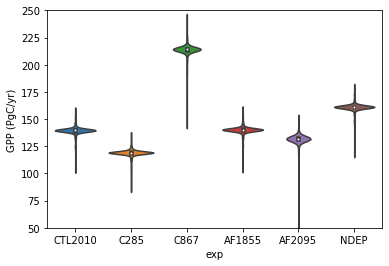

In [17]:
sns.violinplot(data=df,y='GPP',x='exp')
plt.ylabel('GPP (PgC/yr)')
plt.ylim([50,250]);

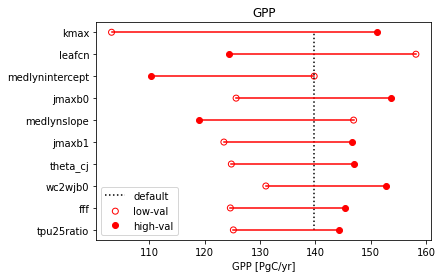

In [18]:
ee='CTL2010'
da=x[ee]
da.attrs={'units':'PgC/yr'}
rank_plot(da,dsets[ee],10)

In [19]:
ee='CTL2010'
ds=dsets[ee]
ix=(ds.param=='kmax')&(ds.minmax=='min')

gpp1=amean(ds.GPP.isel(ens=ix)).mean(dim='year')


In [20]:
gpp0=ds.GPP.isel(ens=0)

In [21]:
## AF2095-OAAT0058 looks buggy
ee='AF2095'
ix=x[ee].argmin()
print(dsets[ee].key[ix].values,':',dsets[ee].param[ix].values,'-',dsets[ee].minmax[ix].values)
xx={exp:np.round((x[exp][ix]/x[exp][0]).values,2) for exp in exps}
xx

OAAT0058 : csol_sand - min


{'CTL2010': 1.0,
 'C285': 1.0,
 'C867': 1.0,
 'AF1855': 1.0,
 'AF2095': 0.08,
 'NDEP': 1.0}

In [26]:
cfs

{'GPP': [86400, 1e-09]}

In [28]:
v2 in cfs

False

In [29]:
exps

['CTL2010', 'C285', 'C867', 'AF1855', 'AF2095', 'NDEP']

In [34]:
v2='TLAI'
x2={exp:amean(gmean(dsets[exp][v2],dsets[exp].la)).mean(dim='year') for exp in exps}

In [35]:
data2={'TLAI':np.concatenate([x2[exp].values for exp in x2]),
      'exp':np.concatenate([np.tile(exp,nens) for exp in x2])}
df2=pd.DataFrame(data2)

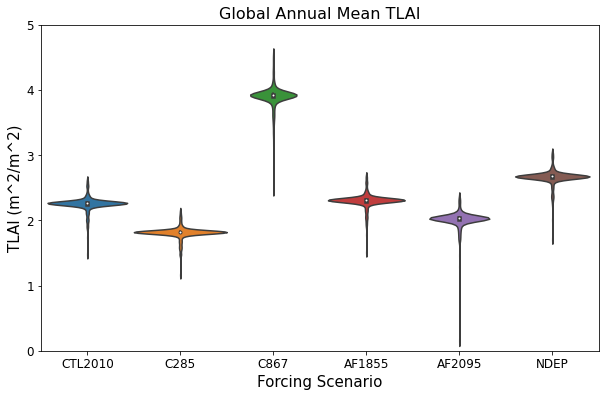

In [62]:
fig = plt.figure(figsize=(10,6))
sns.violinplot(data=df2,y='TLAI',x='exp',width=1)
plt.ylabel('TLAI (m^2/m^2)', fontsize=15)
plt.ylim([0,5])
plt.yticks(fontsize=12)
plt.xlabel('Forcing Scenario', fontsize=15)
plt.xticks(fontsize=12)
plt.title('Global Annual Mean TLAI', fontsize=16);
#plt.savefig('../figs/oaat/TLAI_violinplot.png', bbox_inches='tight')

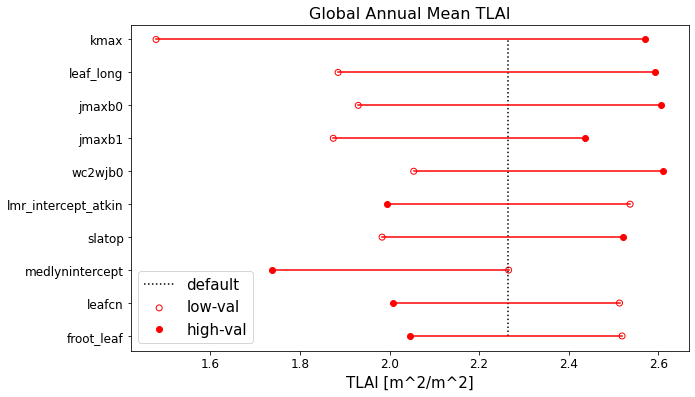

In [75]:
ee='CTL2010'
da2=x2[ee]
da2.attrs={'units':'m^2/m^2'}
fig = plt.figure(figsize=(10,6))
plt.xticks(fontsize=12)
plt.xlabel('TLAI (m^2/m^2)', fontsize=15)
plt.yticks(fontsize=12)
rank_plot(da2,dsets[ee],10)
plt.title('Global Annual Mean TLAI', fontsize=16);
plt.legend(fontsize=15);
#plt.savefig('../figs/oaat/CTL2010_TLAI_global_top10.png', bbox_inches='tight')